In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/retina-unet-master

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/retina-unet-master


In [0]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision as tv
from PIL import Image
import sys
device = torch.device("cuda:0")

In [0]:
trainImages = np.zeros((20, 584, 565))
trainTruth = np.zeros((20, 584, 565))
for i in range(21,41):
    # mask = np.array(Image.open(f"./Training/background_masks/{i}_training_mask.gif"))/255
    trainImages[i - 21,:,:] = cv.imread(f"./Training/original_retinal_images/{i}_training.tif")[:,:,1]
    trainTruth[i - 21,:,:] = np.array(Image.open(f"./Training/blood_vessel_segmentation_masks/{i}_manual1.gif"))/255
testImages = np.zeros((20, 584, 565))
testTruth = np.zeros((20, 584, 565))
for i in range(1,10):
    mask = np.array(Image.open(f"./tset/background_masks/0{i}_test_mask.gif"))/255
    testImages[i-1,:,:] = cv.imread(f"./tset/original_retinal_images/0{i}_test.tif")[:,:,1] * mask
    testTruth[i-1,:,:] = np.array(Image.open(f"./tset/blood_vessel_segmentation_masks/0{i}_manual1.gif"))/255
for i in range(10,21):
    mask = np.array(Image.open(f"./tset/background_masks/{i}_test_mask.gif"))/255
    testImages[i-1,:,:] = cv.imread(f"./tset/original_retinal_images/{i}_test.tif")[:,:,1] * mask
    testTruth[i-1,:,:] = np.array(Image.open(f"./tset/blood_vessel_segmentation_masks/{i}_manual1.gif"))/255

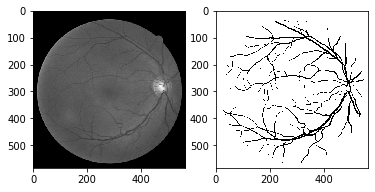

In [4]:
# https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    maxInt = image.max()
    table = np.array([((i / maxInt) ** invGamma) * maxInt 
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv.LUT(image.astype(np.uint8), table)

# def gen_patches(img, truth, num):
#     patchesData = np.zeros((num,48,48)) 
#     patchesTruth = np.zeros((num,48,48))
#     range0 = img.shape[0] - 48
#     range1 = img.shape[1] - 48
#     pts = list(zip((np.random.rand(num) * range0).astype(int), 
#                     (np.random.rand(num) * range1).astype(int)))
#     for i in range(num):
#         x, y = pts[i]
#         patchesData[i,:,:] = img[x:x+48, y:y+48]
#         patchesTruth[i,:,:] = truth[x:x+48, y:y+48]
#     return patchesData, patchesTruth
# def augmentation(imgs,groundTruth,n):
#     pn = 20
#     x, y = np.zeros((n*pn,48,48)),np.zeros((n*pn,48,48))
#     for i in range(pn):
#         x[i*n:(i+1)*n,:,:], y[i*n:(i+1)*n,:,:] = gen_patches(imgs[i,:,:], groundTruth[i,:,:], n)
#     return x,y

def data_generator(grayImages):
    claheImages = np.zeros_like(grayImages)
    print(claheImages.shape)
    clahe = cv.createCLAHE(clipLimit = 2, tileGridSize = (8,8))
    for i in range(20):
        claheImages[i,:,:] = clahe.apply(grayImages[i,:,:].astype(np.uint8))

    gammaImages = np.zeros_like(grayImages)
    for i in range(20):
        gammaImages[i,:,:] = adjust_gamma(claheImages[i, :, :], 1.2)

    stImages = np.zeros_like(grayImages)
    for i in range(20):
        stImages[i,:,:] = ((gammaImages[i,:,:] - gammaImages[i,:,:].mean())
                            /gammaImages[i,:,:].std())
        
    print(stImages[i,:,:].max() - stImages[i,:,:].min())
    for i in range(20):
        stImages[i,:,:] = ((stImages[i,:,:] - stImages[i,:,:].min())
                            /(stImages[i,:,:].max() - stImages[i,:,:].min()))
    
    return stImages
    
plt.subplot(121),plt.imshow(testImages[19,:,:], cmap = 'gray')
plt.subplot(122),plt.imshow(testTruth[19,:,:], cmap = 'binary')
plt.show()

In [0]:
h, w = testImages[0,:,:].shape
hpad = int(np.ceil(h/224) * 224 - h)
wpad = int(np.ceil(w/224) * 224 - w)
# hpad + h, wpad + w

(20, 672, 672)
4.280219533587774
1.0


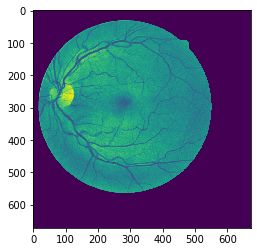

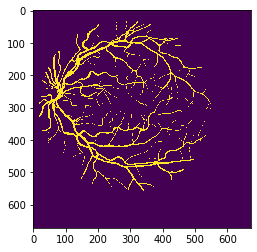

In [6]:
h, w = testImages[0].shape
hpad = int(np.ceil(h/224) * 224 - h)
wpad = int(np.ceil(w/224) * 224 - w)
padTestImages = np.zeros((20,672,672))
padTestTruth = np.zeros((20,672,672))
for i in range(20):
    padTestImages[i] = np.pad(testImages[i], ((0,hpad),(0,wpad)), 'constant', constant_values = 0)
    padTestTruth[i] = np.pad(testTruth[i], ((0,hpad),(0,wpad)), 'constant', constant_values = 0)
padTestImages = data_generator(padTestImages)
# def reconstruct(testImages, testTruth, img):
#     test_x = np.zeros(12*13, 48, 48)
#     test_y = np.zeros(12*13, 48, 48)
#     for i in range(13):
#         for j in range(12):
#             test_x[i*12 + j] = testImages[img,i*48:(i+1)*48, j*48:(j+1)*48]
#             test_y[i*12 + j] = testTruth[img,i*48:(i+1)*48, j*48:(j+1)*48]
#     return test_x, test_y
print(padTestImages[0,:,:].max())
plt.imshow((padTestImages[0,:,:]*255).astype(np.uint8))
plt.show()
plt.imshow((padTestTruth[0,:,:]*255).astype(np.uint8))


In [0]:
from torchvision import models
base_model = models.resnet18(pretrained=False)

In [0]:
class MyResNet(models.ResNet):
    def __init__(self):
        super(MyResNet, self).__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=2)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

In [0]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = MyResNet()
        
        
        self.base_layers = list(self.base_model.children())             
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)           
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [0]:
from collections import defaultdict
import torch.nn.functional as F
import torch

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                epoch_samples += inputs.size(0)
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
PATH = '../trained_model.pkl'
model = torch.load(PATH)

(20, 672, 672) (20, 672, 672)


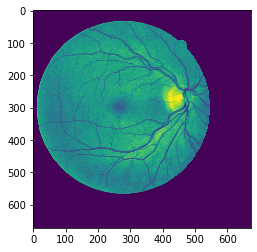

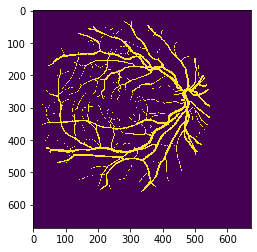

In [12]:
print(padTestImages.shape, padTestTruth.shape)
evalCanvas = np.zeros(padTestImages.shape).astype(np.float32)

plt.imshow((padTestImages[1,:,:]*255).astype(np.uint8))
plt.show()
plt.imshow((padTestTruth[1,:,:]*255).astype(np.uint8))

In [13]:
evalCanvas.shape

(20, 672, 672)

In [0]:
#### prediction

import math

model.eval()   # Set model to evaluate mode


tiTensors = torch.utils.data.TensorDataset(torch.tensor(padTestImages), 
                                           torch.tensor(padTestTruth))
testloader = torch.utils.data.DataLoader(tiTensors, batch_size=1, shuffle = False)

idx = 0     
for inputs, labels in testloader:
    inputs = inputs.to(device).unsqueeze(0)
    # print('inputs',inputs.shape)
    labels = labels.to(device).unsqueeze(0)
    # print('labels',labels.shape)
    for i in range(0, 672, 224):
        for j in range(0, 672, 224):
            # print('**',inputs[:,:,i:i+224, j:j+224].shape)
            pred = model(inputs[:,:,i:i+224, j:j+224].float())
            # print('pred',pred.shape)
            pred = torch.sigmoid(pred)
            pred = pred.data.cpu().numpy()
            evalCanvas[idx, i:i+224, j:j+224] = pred[0,0,:,:]/pred[0,0,:,:].max()*255
            # plt.imshow(pred[0,0,:,:]*255)
            # plt.show()
    idx += 1

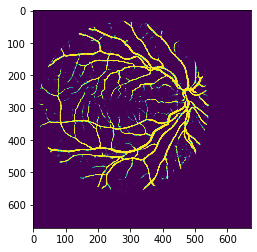

In [15]:
plt.imshow(evalCanvas[1,:,:] * 255)

255.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fad020f27b8>,
 <matplotlib.image.AxesImage at 0x7fad02058128>)

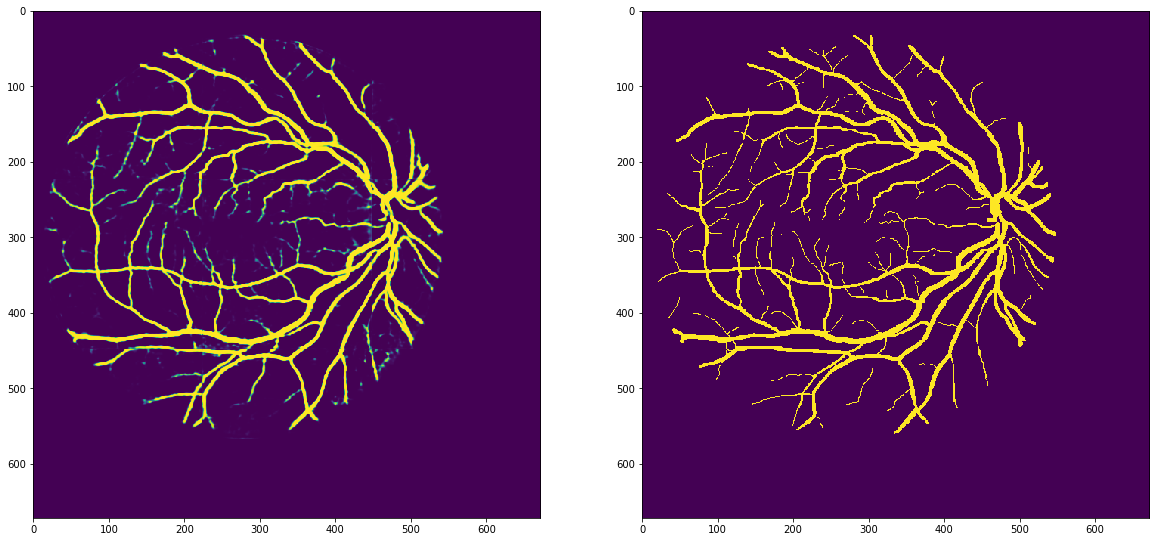

In [16]:
plt.figure(figsize = (20,20))
print(evalCanvas[0,:,:].max())

# tempImg = (evalCanvas[0,:,:]/evalCanvas[0,:,:].max() * 255).astype(np.uint8)
i = 1
plt.subplot(121),plt.imshow(evalCanvas[i,:,:])
plt.subplot(122),plt.imshow(padTestTruth[i,:,:])

In [17]:
((evalCanvas[i,:,:] > 10) * (padTestTruth[i,:,:] == 1)).sum()/(padTestTruth[i,:,:] == 1).sum()

0.9125184965966262

In [0]:
thresholding = np.zeros_like(evalCanvas)
th = 200
for i in range(20):
    thresholding[i,:,:] = evalCanvas[i,:,:]
    thresholding[i,:,:][thresholding[i,:,:] >= th] = 255
    thresholding[i,:,:][thresholding[i,:,:] < th] = 0

In [0]:
for i in range(20):
    newImage = np.zeros((672,672 * 2))
    l = (evalCanvas[i,:,:] - evalCanvas[i,:,:].min())/(evalCanvas[i,:,:].max() - evalCanvas[i,:,:].min())
    r = padTestTruth[i,:,:]
    newImage = np.concatenate((l * 255, r * 255), axis = 1)
    cv.imwrite(f"/gdrive/My Drive/Colab Notebooks/retina-unet-master/task2_final_result/{i + 1}output.jpg", newImage)

In [20]:
for i in range(20):
    newImage = np.zeros((672,672 * 2))
    l = thresholding[i,:,:]
    r = padTestTruth[i,:,:]
    newImage = np.concatenate((l, r * 255), axis = 1)
    print(cv.imwrite(f"/gdrive/My Drive/Colab Notebooks/retina-unet-master/task2_final_01_result/{i + 1}output.jpg", newImage))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:

thresholding = np.zeros_like(evalCanvas)
th = 75
for i in range(20):
    thresholding[i,:,:] = evalCanvas[i,:,:]
    thresholding[i,:,:][thresholding[i,:,:] >= th] = 255
    thresholding[i,:,:][thresholding[i,:,:] < th] = 0

In [0]:
k = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# k = cv.getStructuringElement(cv.MORPH_CROSS,(5,5))
# k = cv.getStructuringElement(cv.MORPH_RECT,(3,3))

In [0]:
# k = np.ones((3,3))
for i in range(20):
    thresholding[i,:,:] = cv.morphologyEx(thresholding[i,:,:], cv.MORPH_CLOSE, k, iterations = 1)
k2 = np.ones((3,3))
for i in range(20):
    thresholding[i,:,:] = cv.morphologyEx(thresholding[i,:,:], cv.MORPH_OPEN, k, iterations = 1)

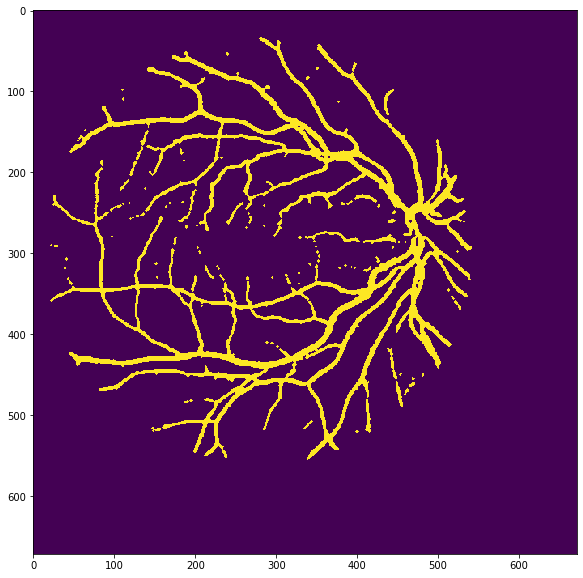

In [24]:
# 0: recall 1: accuracy 2: precision 3: f1-score
metrics = np.zeros((20,4))

for i in range(20):
    tp = ((thresholding[i,:,:] == 255)* (padTestTruth[i,:,:] == 1)).sum()
    tn = ((thresholding[i,:,:] == 0)* (padTestTruth[i,:,:] == 0)).sum()
    fp = ((thresholding[i,:,:] == 255)* (padTestTruth[i,:,:] == 0)).sum()
    fn = ((thresholding[i,:,:] == 0)* (padTestTruth[i,:,:] == 1)).sum()
    metrics[i, 0] = tp/(tp + fn)
    metrics[i, 1] = tp/(tp + fp)
    metrics[i, 2] = (tp + tn)/(tp + tn + fp + fn)
    metrics[i, 3] = 2 * metrics[i, 0] * metrics[i, 1]/(metrics[i, 0] + metrics[i, 1])
plt.figure(figsize = (10,10))
plt.imshow(thresholding[1,:,:])

In [25]:
metrics[:,3].mean()

0.7664899486671767

In [26]:
np.array(sorted(metrics[:,0])).mean() # recall decrease with th up

0.7781538272780388

In [27]:
np.array(sorted(metrics[:,1])[:]).mean() # precision increase with th up

0.7600247637495738

In [28]:
np.array(sorted(metrics[:,2])[:]).mean() # accuracy

0.969850459715136

In [29]:
np.array(np.array(sorted(metrics[:,3]))).mean() # f1-score


0.7664899486671766

In [30]:
sum([0.7493768499766319,
 0.7503538673336824,
 0.7540576006630293,
 0.7549131826559318,
 0.763211230345828,
 0.7632727028659642,
 0.764522328532165,
 0.7755604002459612,
 0.7958277187203673,
 0.8120401601672683])/10

0.7683136041506831

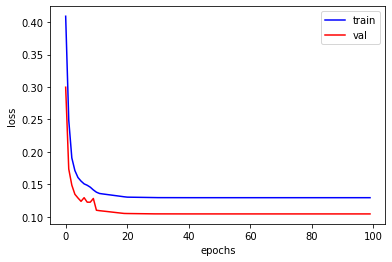

In [34]:
file = open("/gdrive/My Drive/Colab Notebooks/Epochs.txt")
file2 = open("/gdrive/My Drive/Colab Notebooks/epochs1.txt")

info = list(file)

train = [i.split()[-1] for i in info if i[0] == "t"]
val = [i.split()[-1] for i in info if i[0] == "v"]

train = np.array(train).astype(float)

val = np.array(val).astype(float)

a, = plt.plot(np.arange(100), train, c = 'blue', label='train')
b, = plt.plot(np.arange(100), val, c = 'red', label = 'val')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(handles = [a, b])

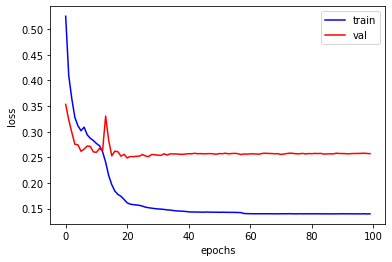

In [35]:
file = open("/gdrive/My Drive/Colab Notebooks/Epochs.txt")
file2 = open("/gdrive/My Drive/Colab Notebooks/epochs1.txt")

info = list(file2)

train = [i.split()[-1] for i in info if i[0] == "t"]
val = [i.split()[-1] for i in info if i[0] == "v"]

train = np.array(train).astype(float)

val = np.array(val).astype(float)

a, = plt.plot(np.arange(100), train, c = 'blue', label='train')
b, = plt.plot(np.arange(100), val, c = 'red', label = 'val')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(handles = [a, b])